/Users/mikeshinoda/Library/Caches/pypoetry/virtualenvs/ai-algo-ozOH1ZQc-py3.12/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/var/folders/nj/lm1sfpms65z1jzzh7ppm1f0c0000gn/T/ipykernel_43700/3719626240.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  torch.FloatTensor(states).to(device),


Episode 1, Reward: -1290.56, Average Reward: -1290.56
Episode 2, Reward: -1651.81, Average Reward: -1471.19
Episode 3, Reward: -1387.10, Average Reward: -1443.16
Episode 4, Reward: -1711.44, Average Reward: -1510.23
Episode 5, Reward: -1535.38, Average Reward: -1515.26
Episode 6, Reward: -1370.71, Average Reward: -1491.17
Episode 7, Reward: -1349.83, Average Reward: -1470.98
Episode 8, Reward: -1623.62, Average Reward: -1490.06
Episode 9, Reward: -1772.48, Average Reward: -1521.44
Episode 10, Reward: -1215.22, Average Reward: -1490.82
Episode 11, Reward: -1774.30, Average Reward: -1539.19
Episode 12, Reward: -1344.05, Average Reward: -1508.41
Episode 13, Reward: -1300.03, Average Reward: -1499.71
Episode 14, Reward: -1119.89, Average Reward: -1440.55
Episode 15, Reward: -883.67, Average Reward: -1375.38
Episode 16, Reward: -982.80, Average Reward: -1336.59
Episode 17, Reward: -527.22, Average Reward: -1254.33
Episode 18, Reward: -890.61, Average Reward: -1181.03
Episode 19, Reward: -89

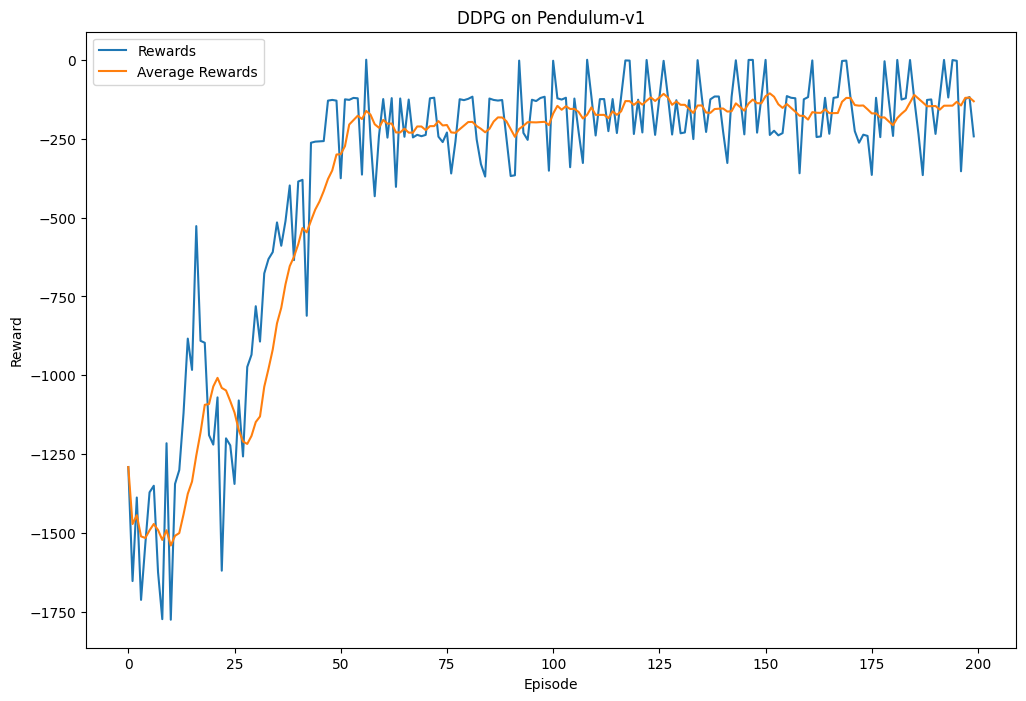

Evaluation Episode 1, Reward: -114.74
Evaluation Episode 2, Reward: -329.56
Evaluation Episode 3, Reward: -251.93
Evaluation Episode 4, Reward: -240.13
Evaluation Episode 5, Reward: -2.11
Evaluation Episode 6, Reward: -120.87
Evaluation Episode 7, Reward: -123.07
Evaluation Episode 8, Reward: -1.08
Evaluation Episode 9, Reward: -119.70
Evaluation Episode 10, Reward: -123.83
Average Evaluation Reward over 10 episodes: -142.70


In [3]:
import gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 设置随机种子以确保结果可重复
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ReplayBuffer:
    """
    经验回放缓冲区
    """

    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.FloatTensor(states).to(device),
            torch.FloatTensor(actions).to(device),
            torch.FloatTensor(rewards).unsqueeze(1).to(device),
            torch.FloatTensor(next_states).to(device),
            torch.FloatTensor(dones).unsqueeze(1).to(device)
        )

    def __len__(self):
        return len(self.memory)


class Actor(nn.Module):
    """
    策略网络（Actor）
    """

    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # 使用 tanh 激活函数并缩放到动作空间
        x = torch.tanh(self.fc3(x)) * self.max_action
        return x


class Critic(nn.Module):
    """
    价值网络（Critic）
    """

    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Q1 architecture
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)  # 拼接状态和动作
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DDPGAgent:
    """
    DDPG 代理
    """

    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.replay_buffer = ReplayBuffer(buffer_size=int(1e6), batch_size=64)
        self.max_action = max_action

        self.gamma = 0.99
        self.tau = 0.005  # 软更新参数

    def select_action(self, state, noise=0.1):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy().flatten()
        self.actor.train()
        # 添加噪声以进行探索
        action += noise * np.random.randn(len(action))
        return np.clip(action, -self.max_action, self.max_action)

    def train(self):
        if len(self.replay_buffer) < self.replay_buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample()

        # 计算目标 Q 值
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_Q = self.critic_target(next_states, next_actions)
            target_Q = rewards + (1 - dones) * self.gamma * target_Q

        # 当前 Q 值
        current_Q = self.critic(states, actions)

        # 计算 Critic 损失
        critic_loss = F.mse_loss(current_Q, target_Q)

        # 优化 Critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 计算 Actor 损失
        actor_loss = -self.critic(states, self.actor(states)).mean()

        # 优化 Actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 软更新目标网络
        self.soft_update(self.critic, self.critic_target)
        self.soft_update(self.actor, self.actor_target)

    def soft_update(self, source, target):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) + param.data * self.tau
            )


def plot_rewards(rewards, avg_rewards):
    plt.figure(figsize=(12, 8))
    plt.plot(rewards, label='Rewards')
    plt.plot(avg_rewards, label='Average Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('DDPG on Pendulum-v1')
    plt.legend()
    plt.show()


def main():
    env = gym.make('Pendulum-v1')
    # env.seed(SEED)  # 移除此行
    torch.manual_seed(SEED)
    np.random.seed(SEED)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = DDPGAgent(state_dim, action_dim, max_action)

    num_episodes = 200
    max_steps = 200
    rewards = []
    avg_rewards = []

    for episode in range(1, num_episodes + 1):
        state, info = env.reset(seed=SEED + episode)  # 设置种子
        episode_reward = 0

        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            done = done or truncated
            agent.replay_buffer.add(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            episode_reward += reward
            if done:
                break

        rewards.append(episode_reward)
        avg_reward = np.mean(rewards[-10:])
        avg_rewards.append(avg_reward)

        print(f"Episode {episode}, Reward: {episode_reward:.2f}, Average Reward: {avg_reward:.2f}")

    # 绘制奖励曲线
    plot_rewards(rewards, avg_rewards)

    # 评估策略
    evaluate_policy(env, agent, num_episodes=10)

    env.close()


def evaluate_policy(env, agent, num_episodes=10):
    """
    使用学习到的策略评估代理
    """
    eval_rewards = []
    for episode in range(1, num_episodes + 1):
        state, info = env.reset(seed=SEED + 1000 + episode)  # 设置种子
        episode_reward = 0
        done = False
        while not done:
            action = agent.select_action(state, noise=0.0)  # 不添加噪声
            next_state, reward, done, truncated, info = env.step(action)
            done = done or truncated
            state = next_state
            episode_reward += reward
        eval_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode}, Reward: {episode_reward:.2f}")
    avg_eval_reward = np.mean(eval_rewards)
    print(f"Average Evaluation Reward over {num_episodes} episodes: {avg_eval_reward:.2f}")


if __name__ == "__main__":
    main()
